In [250]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.auto import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
%load_ext autoreload
%autoreload 2
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../../figures/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
DATADIR = Path('/data/gpfs-1/users/peidlis_c/work/data/perturbation_resource_paper')
TEMPDIR = Path("/fast/scratch/users/peidlis_c/perturbation_resource_paper/")

In [252]:
def load_adf(dataset):
    # Find files
    P = Path('/fast/scratch/users/peidlis_c/perturbation_resource_paper/sweep/')
    files = [f for f in P.glob('*_tables.csv') if dataset in f.name]

    # collect results
    dfs = []
    for f in tqdm(files, leave=False):
        s = f.name.split('_')
        df = pd.read_csv(P / f, index_col=0)
        df['ncounts'] = int(s[-5])
        df['ncells'] = int(s[-4])
        df['npcs'] = int(s[-3])
        df['nhvgs'] = int(s[-2])

        dfs.append(df)
    adf = pd.concat(dfs)
    return adf

In [253]:
dataset = 'NormanWeissman2019_filtered'
adf = load_adf(dataset)

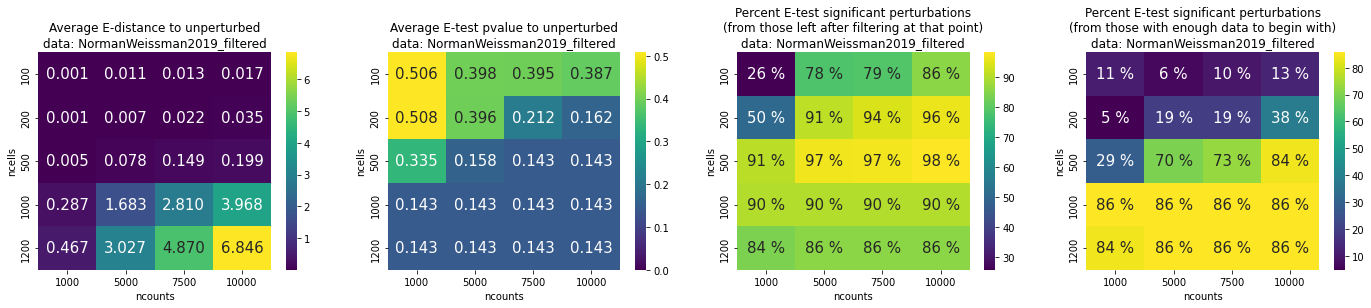

In [254]:
x = 'ncells'
y = 'ncounts'

# selecte perturbations that remain even with harshest filters
fulls = adf[(adf[x]==adf[x].max()) & (adf[y]==adf[y].max())].index.unique()

K = 4
fix, axs = pl.subplots(1,K, figsize=(6*K,4))

ax = axs[0]
Z = pd.pivot_table(adf[(adf.index.isin(fulls)) & (adf.npcs==50) & (adf.nhvgs==2000)], index=x, columns=y, values='edist', aggfunc='mean')
sns.heatmap(Z, cmap='viridis', annot=True, fmt=".3f", annot_kws={'size': 15}, ax=ax)
ax.set_title(f'Average E-distance to unperturbed\ndata: {dataset}')

ax = axs[1]
Z = pd.pivot_table(adf[(adf.index.isin(fulls)) & (adf.npcs==50) & (adf.nhvgs==2000)], 
                   index=x, columns=y, values='pvalue', aggfunc='mean')
sns.heatmap(Z, cmap='viridis', annot=True, fmt=".3f", annot_kws={'size': 15}, ax=ax, vmin=0)
ax.set_title(f'Average E-test pvalue to unperturbed\ndata: {dataset}')

ax = axs[2]
# This is biased by perturbations removed...
Z = adf.value_counts(['significant', x, y], sort=False, dropna=False)
percent_significant = Z.loc[True, :] / (Z.loc[True, :] + Z.loc[False, :])
V = percent_significant.unstack(level=1).dropna()*100
sns.heatmap(V, cmap='viridis', annot=True, fmt=".0f", annot_kws={'size': 15}, ax=ax)
for t in ax.texts: t.set_text(t.get_text() + " %")
ax.set_title(f'Percent E-test significant perturbations\n(from those left after filtering at that point)\ndata: {dataset}')

ax = axs[3]
Z = adf[adf.index.isin(fulls)].value_counts(['significant', x, y], sort=False, dropna=False)
percent_significant = Z.loc[True, :] / (Z.loc[True, :] + Z.loc[False, :])
V = percent_significant.unstack(level=1).dropna()*100
sns.heatmap(V, cmap='viridis', annot=True, fmt=".0f", annot_kws={'size': 15}, ax=ax)
for t in ax.texts: t.set_text(t.get_text() + " %")
ax.set_title(f'Percent E-test significant perturbations\n(from those with enough data to begin with)\ndata: {dataset}')

pl.show()

In [255]:
adf

,edist,pvalue,significant,pvalue_adj,significant_adj,ncounts,ncells,npcs,nhvgs
AHR,1.082959,0.0001,True,0.006579,True,5000,500,100,500
BAK1,0.000298,0.4400,False,0.686400,False,5000,500,100,500
BCL2L11,0.786241,0.0001,True,0.006579,True,5000,500,100,500
BCORL1,0.876059,0.0001,True,0.006579,True,5000,500,100,500
C19orf26,0.309726,0.0001,True,0.006579,True,5000,500,100,500
...,...,...,...,...,...,...,...,...,...
ZBTB25,1.109512,0.0001,True,0.006579,True,5000,500,50,2000
ZC3HAV1,1.904867,0.0001,True,0.006579,True,5000,500,50,2000
ZC3HAV1_HOXC13,1.343581,0.0001,True,0.006579,True,5000,500,50,2000
ZNF318,1.130692,0.0001,True,0.006579,True,5000,500,50,2000


In [258]:
dataset = 'ZhaoSims2021'
adf = load_adf(dataset)

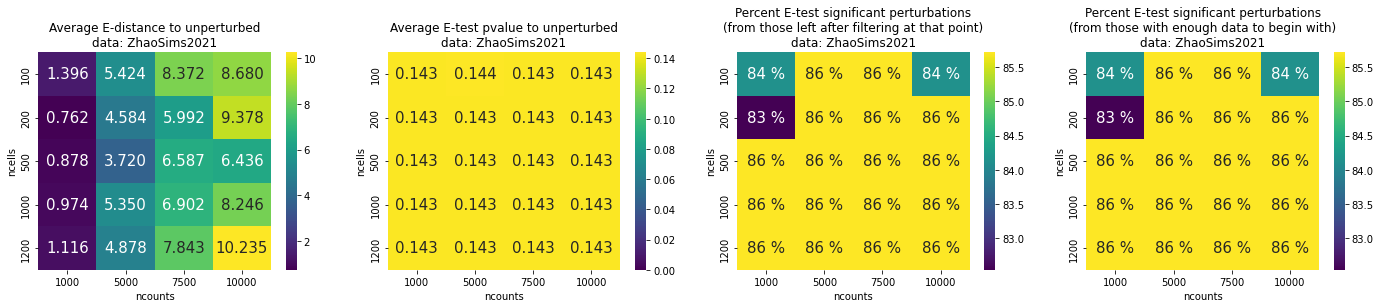

In [257]:
x = 'ncells'
y = 'ncounts'

# selecte perturbations that remain even with harshest filters
fulls = adf[(adf[x]==adf[x].max()) & (adf[y]==adf[y].max())].index.unique()

K = 4
fix, axs = pl.subplots(1,K, figsize=(6*K,4))

ax = axs[0]
Z = pd.pivot_table(adf[(adf.index.isin(fulls)) & (adf.npcs==50) & (adf.nhvgs==2000)], index=x, columns=y, values='edist', aggfunc='mean')
sns.heatmap(Z, cmap='viridis', annot=True, fmt=".3f", annot_kws={'size': 15}, ax=ax)
ax.set_title(f'Average E-distance to unperturbed\ndata: {dataset}')

ax = axs[1]
Z = pd.pivot_table(adf[(adf.index.isin(fulls)) & (adf.npcs==50) & (adf.nhvgs==2000)], 
                   index=x, columns=y, values='pvalue', aggfunc='mean')
sns.heatmap(Z, cmap='viridis', annot=True, fmt=".3f", annot_kws={'size': 15}, ax=ax, vmin=0)
ax.set_title(f'Average E-test pvalue to unperturbed\ndata: {dataset}')

ax = axs[2]
# This is biased by perturbations removed...
Z = adf.value_counts(['significant', x, y], sort=False, dropna=False)
percent_significant = Z.loc[True, :] / (Z.loc[True, :] + Z.loc[False, :])
V = percent_significant.unstack(level=1).dropna()*100
sns.heatmap(V, cmap='viridis', annot=True, fmt=".0f", annot_kws={'size': 15}, ax=ax)
for t in ax.texts: t.set_text(t.get_text() + " %")
ax.set_title(f'Percent E-test significant perturbations\n(from those left after filtering at that point)\ndata: {dataset}')

ax = axs[3]
Z = adf[adf.index.isin(fulls)].value_counts(['significant', x, y], sort=False, dropna=False)
percent_significant = Z.loc[True, :] / (Z.loc[True, :] + Z.loc[False, :])
V = percent_significant.unstack(level=1).dropna()*100
sns.heatmap(V, cmap='viridis', annot=True, fmt=".0f", annot_kws={'size': 15}, ax=ax)
for t in ax.texts: t.set_text(t.get_text() + " %")
ax.set_title(f'Percent E-test significant perturbations\n(from those with enough data to begin with)\ndata: {dataset}')

pl.show()

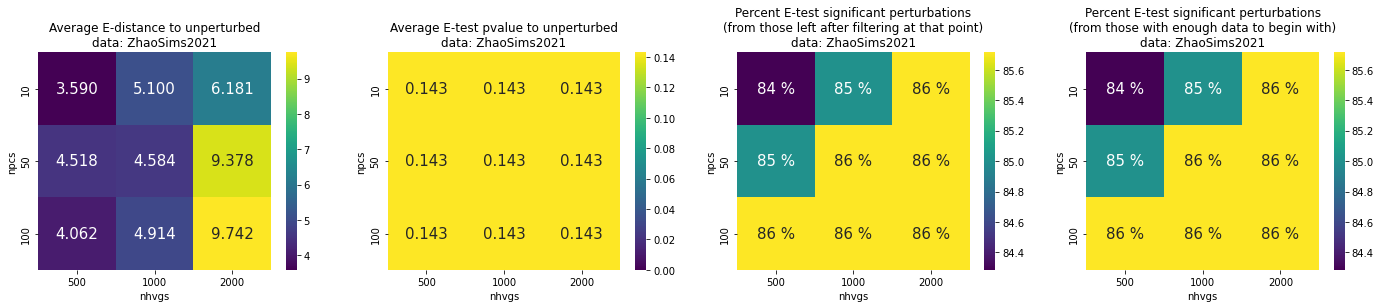

In [259]:
x = 'npcs'
y = 'nhvgs'

# selecte perturbations that remain even with harshest filters
fulls = adf[(adf[x]==adf[x].max()) & (adf[y]==adf[y].max())].index.unique()

K = 4
fix, axs = pl.subplots(1,K, figsize=(6*K,4))

defaults = (adf.ncells==200) & (adf.ncounts==10000)

ax = axs[0]
Z = pd.pivot_table(adf[(adf.index.isin(fulls)) & defaults], index=x, columns=y, values='edist', aggfunc='mean')
sns.heatmap(Z, cmap='viridis', annot=True, fmt=".3f", annot_kws={'size': 15}, ax=ax)
ax.set_title(f'Average E-distance to unperturbed\ndata: {dataset}')

ax = axs[1]
Z = pd.pivot_table(adf[(adf.index.isin(fulls)) & defaults], 
                   index=x, columns=y, values='pvalue', aggfunc='mean')
sns.heatmap(Z, cmap='viridis', annot=True, fmt=".3f", annot_kws={'size': 15}, ax=ax, vmin=0)
ax.set_title(f'Average E-test pvalue to unperturbed\ndata: {dataset}')

ax = axs[2]
# This is biased by perturbations removed...
Z = adf.value_counts(['significant', x, y], sort=False, dropna=False)
percent_significant = Z.loc[True, :] / (Z.loc[True, :] + Z.loc[False, :])
V = percent_significant.unstack(level=1).dropna()*100
sns.heatmap(V, cmap='viridis', annot=True, fmt=".0f", annot_kws={'size': 15}, ax=ax)
for t in ax.texts: t.set_text(t.get_text() + " %")
ax.set_title(f'Percent E-test significant perturbations\n(from those left after filtering at that point)\ndata: {dataset}')

ax = axs[3]
Z = adf[adf.index.isin(fulls)].value_counts(['significant', x, y], sort=False, dropna=False)
percent_significant = Z.loc[True, :] / (Z.loc[True, :] + Z.loc[False, :])
V = percent_significant.unstack(level=1).dropna()*100
sns.heatmap(V, cmap='viridis', annot=True, fmt=".0f", annot_kws={'size': 15}, ax=ax)
for t in ax.texts: t.set_text(t.get_text() + " %")
ax.set_title(f'Percent E-test significant perturbations\n(from those with enough data to begin with)\ndata: {dataset}')

pl.show()

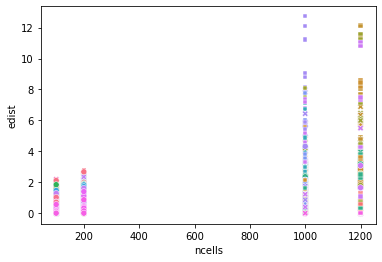

In [192]:
sns.scatterplot(data=adf.reset_index(), x='ncells', y='edist', hue='index', legend=False, style='nhvgs')
pl.show()

In [193]:
# ncounts alone
sdf = pd.pivot(adf[(adf.ncells==200)&(adf.npcs==50)&(adf.nhvgs==2000)], columns= 'ncounts', values='edist')
sdf = sdf.sort_values(10000)
sdf.head()

ncounts,1000,5000,7500,10000
control,0.000000,0.000000,0.000000,0.000000
MAP2K6,0.004785,0.008693,0.054286,0.022925
BAK1,-0.003197,-0.001915,0.017712,0.025239
ETS2,0.002778,-0.003547,0.036305,0.029558
KLF1,-0.002194,0.002740,0.011947,0.032833


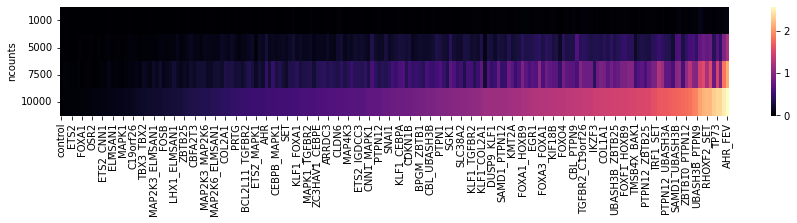

In [197]:
pl.subplots(figsize=(15,2))
sns.heatmap(sdf.T, cmap='magma')
pl.show()